The last notebook had too much -- this one is devoted to an exploration of matplot lib and some attempts to put together functions to be used later on

In [92]:
from fastai2.vision.all import *
import matplotlib.pyplot as plt
import seaborn as sns
from pydicom import dcmread
%matplotlib inline

In [2]:
path = Path('/home/azaidi/Desktop/fastai/nbs/kaggle/osic')
Path.BASE_PATH = path
path.ls()

(#6) [Path('test.csv'),Path('train'),Path('train.csv'),Path('test'),Path('osic-pulmonary-fibrosis-progression.zip'),Path('sample_submission.csv')]

In [3]:
train_path = path/'train'
test_path = path/'test'
train_df = pd.read_csv(path/'train.csv')
test_df = pd.read_csv(path/'test.csv')
sample_sub = pd.read_csv(path/'sample_submission.csv')

In [4]:
#returns a list with the dicoms in order
def dcm_sort(patient_folder):
    #list comprehension that runs through folder of dicoms
    dcm_stacked = [dcmread(dcm) for dcm in patient_folder.ls()]
    dcm_stacked.sort(key=lambda x: int(x.InstanceNumber), reverse=True)
    #returning a python list of dicoms sorted
    return dcm_stacked

#transforms all slices in a scan in hounsfield units 
def ct_transformed_hu(dcm_sorted, threshold=-1000, replace=-1000):
    intercept = dcm_sorted[0].RescaleIntercept
    slices_stacked = np.stack([dcm.pixel_array for dcm in dcm_sorted])
    slices_stacked = slices_stacked.astype(np.int16)
    
    #converts the unknown values to desired replacement
    slices_stacked[slices_stacked <= threshold] = replace
    
    #turn into hounsfield scale
    slices_stacked += np.int16(intercept)
    
    return np.array(slices_stacked, dtype=np.int16)

In [5]:
#transforms all slices in a scan in hounsfield units 
def ct_transformed(dcm_sorted, threshold=-1000, replace=-1000):
    intercept = dcm_sorted[0].RescaleIntercept
    slices_stacked = np.stack([dcm.pixel_array for dcm in dcm_sorted])
    slices_stacked = slices_stacked.astype(np.int16)
    
    #converts the unknown values to desired replacement
    slices_stacked[slices_stacked <= threshold] = replace
    
    #turn into hounsfield scale
    slices_stacked += np.int16(intercept)
    
    return np.array(slices_stacked, dtype=np.int16)

In [6]:
%%time
scans = [dcm_sort(folder) for folder in train_path.ls()]

CPU times: user 19.5 s, sys: 9.88 s, total: 29.4 s
Wall time: 37.6 s


In [7]:
%%time
holder = []
for dcms in scans:
    slice_count = len(dcms)
    dcm = dcms[0]
    pat = train_df[train_df['Patient'] == dcm.PatientID].iloc[0]
    holder.append([pat['Patient'], pat['Age'], pat['Sex'],
                   pat['SmokingStatus'], slice_count, dcm.Rows, 
                   dcm.Columns, dcm.SliceThickness, 
                   dcm.PixelSpacing[0], dcm.PixelSpacing[1], 
                   dcm.Manufacturer, dcm.KVP, 
                   dcm.ConvolutionKernel,dcm.PatientPosition])
    
meta = pd.DataFrame(holder, columns=['patient', 'age',
                                         'sex', 'smoking_status',
                                'num_slices', 'rows', 'columns', 
                              'slice_thickness', 'spacing_x', 
                              'spacing_y', 'manufacturer',
                            'kvp', 'convolution_kernel',
                                        'patient_position'])

CPU times: user 114 ms, sys: 0 ns, total: 114 ms
Wall time: 121 ms


In [9]:
meta

,patient,age,sex,smoking_status,num_slices,rows,columns,slice_thickness,spacing_x,spacing_y,manufacturer,kvp,convolution_kernel,patient_position
0,ID00232637202260377586117,74,Female,Never smoked,67,512,512,5.000,0.683000,0.683000,TOSHIBA,120.0,FC52,FFS
1,ID00134637202223873059688,67,Male,Ex-smoker,451,512,512,1.000,0.740234,0.740234,Philips,120.0,YC,HFS
2,ID00093637202205278167493,69,Male,Ex-smoker,37,512,512,1.000,0.880859,0.880859,SIEMENS,120.0,B60f,FFS
3,ID00307637202282126172865,65,Male,Never smoked,29,512,512,1.000,0.707031,0.707031,SIEMENS,110.0,B90s,HFS
4,ID00364637202296074419422,64,Male,Ex-smoker,33,512,512,1.000,0.712891,0.712891,SIEMENS,100.0,B50f,HFS
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
171,ID00336637202286801879145,56,Male,Ex-smoker,33,512,512,1.000,0.650391,0.650391,SIEMENS,120.0,B70s,FFP
172,ID00383637202300493233675,64,Female,Never smoked,32,512,512,1.000,0.656250,0.656250,SIEMENS,120.0,B50f,HFS
173,ID00067637202189903532242,64,Male,Ex-smoker,319,733,888,1.250,0.871094,0.871094,GE MEDICAL SYSTEMS,120.0,LUNG,FFS
174,ID00317637202283194142136,64,Male,Ex-smoker,521,512,512,0.625,0.677734,0.677734,GE MEDICAL SYSTEMS,120.0,LUNG,FFS


In [81]:
meta.shape

(176, 14)

In [25]:
def scatter_plot(x_val, y_val, alpha=None, title=None,
                x_label=None, y_label=None, color=None):
    plt.title(title)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.scatter(x_val, y_val, alpha=alpha, c=color)

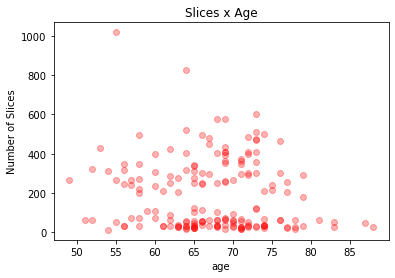

In [32]:
scatter_plot(meta['age'], meta['num_slices'], x_label='age',
            y_label='Number of Slices', title='Slices x Age',
            color='Red', alpha=0.3)

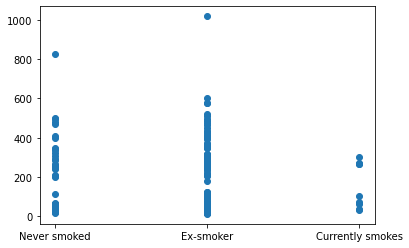

In [34]:
scatter_plot(meta['smoking_status'], meta['num_slices'])

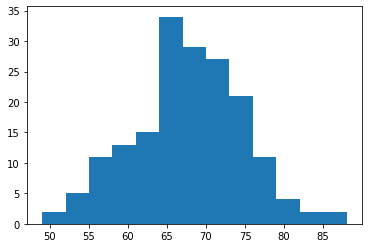

In [49]:
plt.hist(meta['age'], bins='auto', );#density=True);

In [45]:
meta['age'].unique()

array([74, 67, 69, 65, 64, 73, 70, 66, 55, 78, 60, 63, 71, 68, 79, 61, 58,
       81, 53, 72, 77, 51, 54, 62, 83, 56, 59, 75, 52, 57, 76, 49, 87, 88])

Seaborn has a cool heatmap to use: https://seaborn.pydata.org/examples/spreadsheet_heatmap.html

We'll feed this a correlation matrix -- pairwise correlation of columns: https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.corr.html

In [74]:
meta.corr()

,age,num_slices,rows,columns,slice_thickness,spacing_x,spacing_y,kvp
age,1.000000,-0.117859,-0.009105,-0.039026,-0.007130,-0.118770,-0.118770,0.050420
num_slices,-0.117859,1.000000,0.009601,0.002078,-0.309427,0.025499,0.025499,-0.099925
rows,-0.009105,0.009601,1.000000,0.976386,-0.185585,-0.651788,-0.651788,-0.017598
columns,-0.039026,0.002078,0.976386,1.000000,-0.190254,-0.616842,-0.616842,-0.020463
slice_thickness,-0.007130,-0.309427,-0.185585,-0.190254,1.000000,0.141168,0.141168,0.110567
spacing_x,-0.118770,0.025499,-0.651788,-0.616842,0.141168,1.000000,1.000000,-0.046527
spacing_y,-0.118770,0.025499,-0.651788,-0.616842,0.141168,1.000000,1.000000,-0.046527
kvp,0.050420,-0.099925,-0.017598,-0.020463,0.110567,-0.046527,-0.046527,1.000000


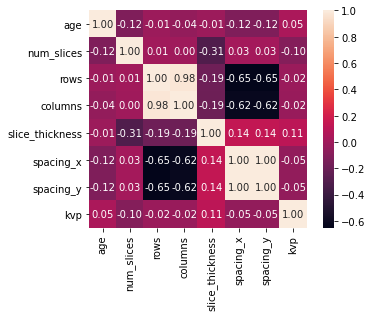

In [77]:
sns.heatmap(meta.corr(method='pearson'), 
            fmt='.2f', square=True, annot=True);

Ok we can see that the rows by columns of the slices is negatively correlated with the pixel spacing(!) meaning as the pixel spacing increases, the rows/columns should descrease -- this adds some coherence, we would hope that is the case

The slice thickness and number of slices are also negatively correlated -- which makes sense, you would presume that the two should not track one another. aka if the slice thickness increases -- we wouldn't be expecting the number of slices to also increase

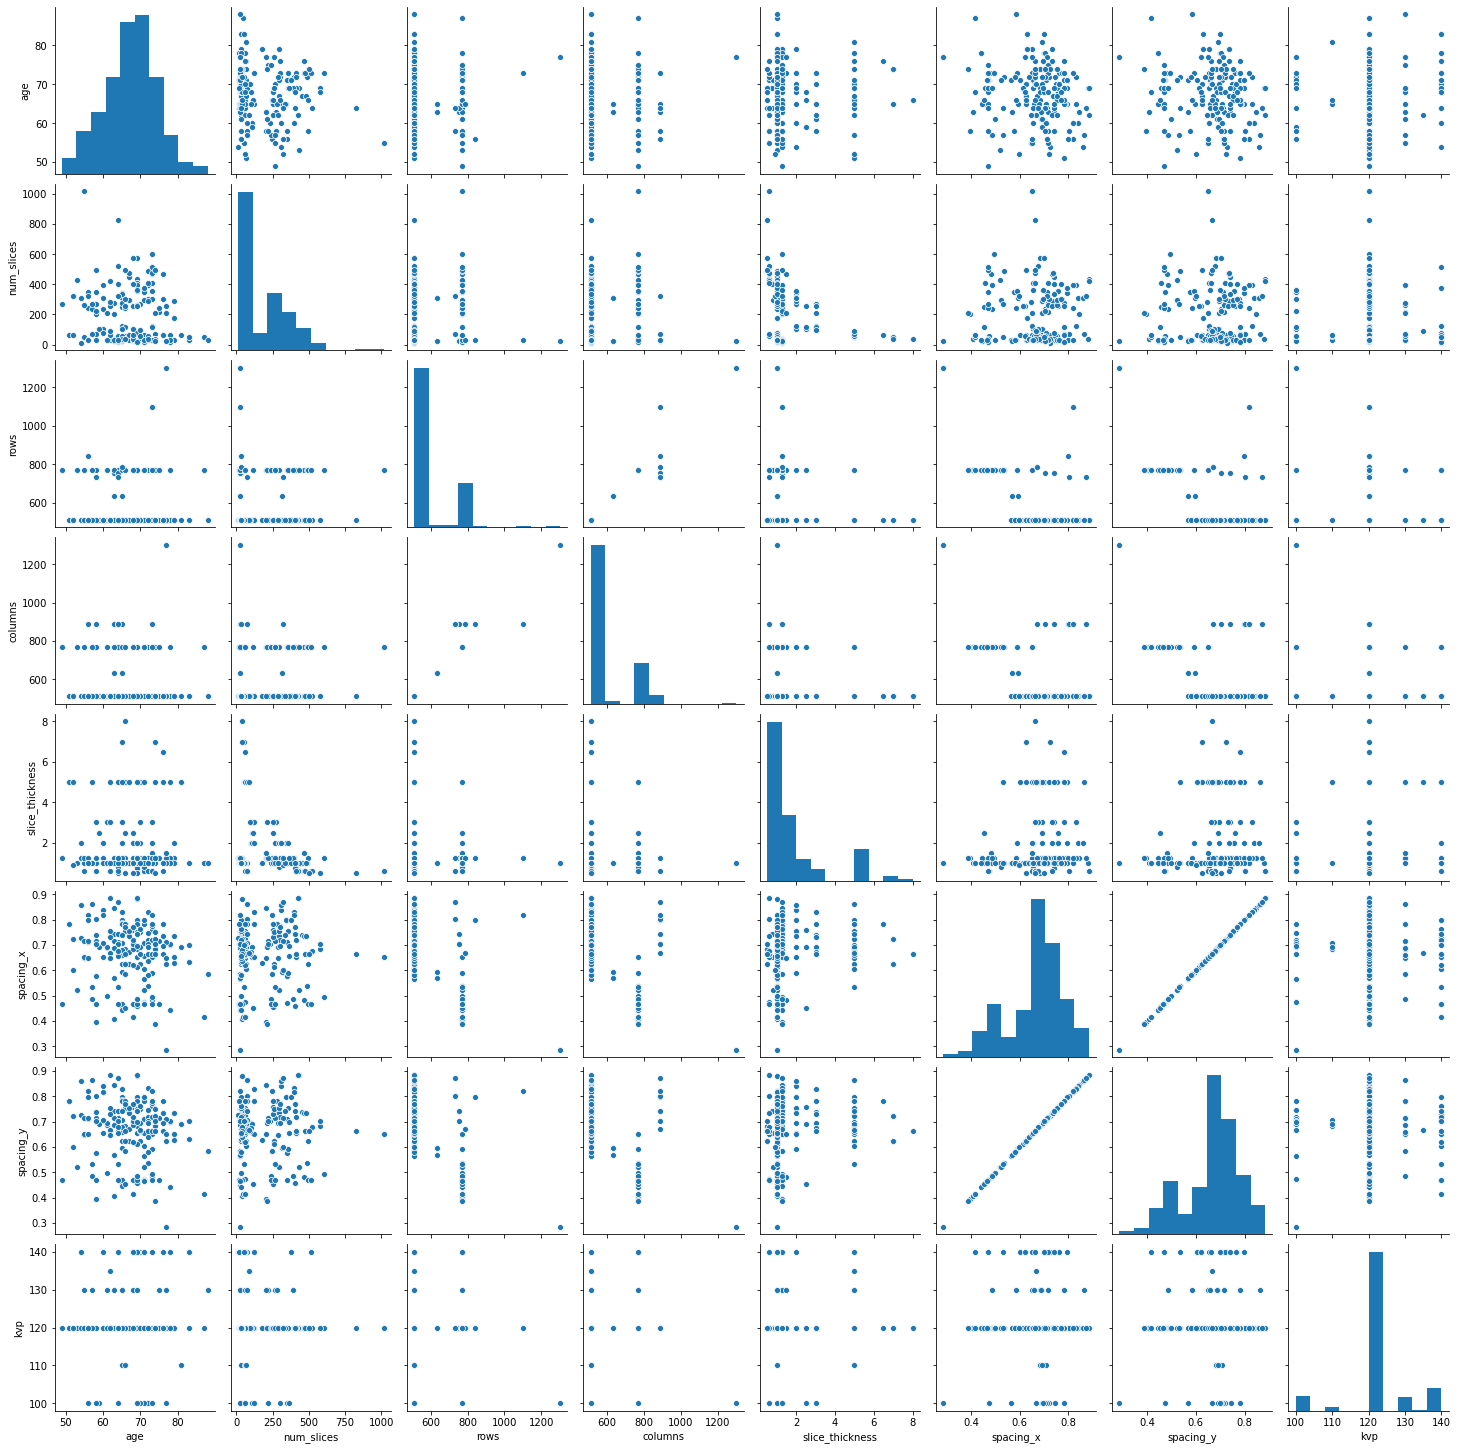

In [80]:
sns.pairplot(meta); #too many columns - let's pick interesting ones

In [94]:
list(meta.columns)

['patient',
 'age',
 'sex',
 'smoking_status',
 'num_slices',
 'rows',
 'columns',
 'slice_thickness',
 'spacing_x',
 'spacing_y',
 'manufacturer',
 'kvp',
 'convolution_kernel',
 'patient_position']

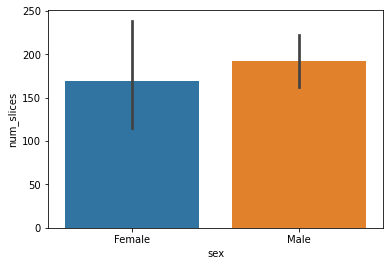

In [98]:
sns.barplot(x='sex', y='num_slices', data=meta);

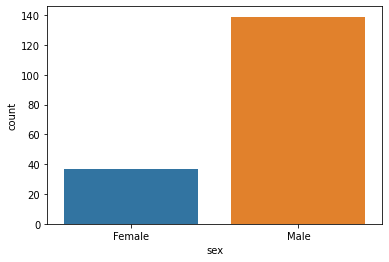

In [101]:
sns.countplot(x='sex', data=meta);

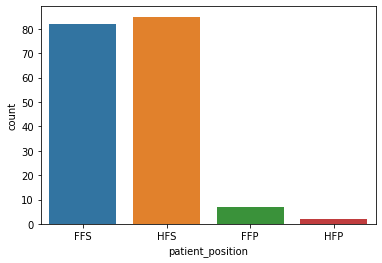

In [104]:
sns.countplot(x='patient_position', data=meta);

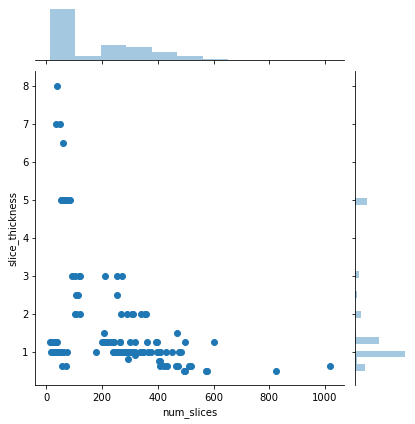

In [109]:
sns.jointplot(data=meta, x='num_slices', y='slice_thickness',
             )# hue='patient_position', kind='')

AttributeError: module 'seaborn' has no attribute 'histplot'

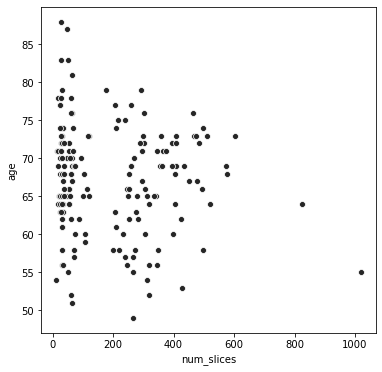

In [114]:
f, ax = plt.subplots(figsize=(6,6))
sns.scatterplot(x=meta['num_slices'], y=meta['age'], color='0.15')
sns.histplot(x=meta['num_slices'], y=meta['age'])

In [115]:
sns.__version__

'0.10.1'